In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# EasyOCR 사용

from ITT import (
    preprocess_image,           # 이미지 로드 (컬러 이미지 반환)
    ocr_with_structure,         # EasyOCR로 단어 단위 탐지
    group_by_line,              # 라인 단위 그룹화
    group_by_paragraph,         # 문단 단위 그룹화
    generate_text_from_data,    # 텍스트 생성
    call_llm_for_correction,    # OCR 교정 (LLM)
    call_llm_for_description,   # LLM 설명 생성
    save_output                 # 결과 저장
)

# 테스트용 이미지 경로
IMAGE_PATH = "img/BB.png"
print(f"테스트 이미지: {IMAGE_PATH}")


테스트 이미지: img/BB.png


이미지 shape: (789, 969, 3)
이미지 dtype: uint8
채널 수: 3


(np.float64(-0.5), np.float64(968.5), np.float64(788.5), np.float64(-0.5))

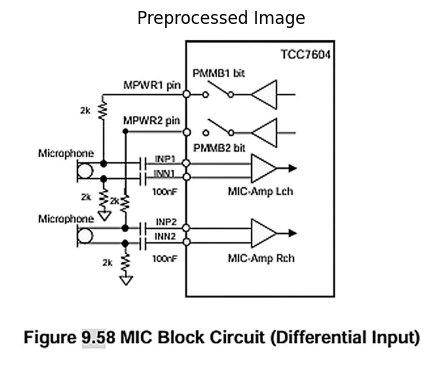

In [32]:
# Step 1: preprocess_image 테스트
# preprocess_image는 원본 컬러 이미지를 반환합니다 (EasyOCR은 컬러 이미지도 처리 가능)
import cv2
import matplotlib.pyplot as plt

img = preprocess_image(IMAGE_PATH)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(f"이미지 shape: {img.shape}")
print(f"이미지 dtype: {img.dtype}")
print(f"채널 수: {img.shape[2] if len(img.shape) == 3 else 1}")

# 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Preprocessed Image")
plt.imshow(img)
plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.title("Image for OCR (RGB)")
# plt.imshow(img_rgb)
# plt.axis('off')

# plt.tight_layout()
# plt.show()


탐지된 단어 개수: 18

처음 10개 단어:
  [1] 'TCCT6DA)' at (615, 35) conf=33% line=1
  [2] 'PMKDI L:' at (414, 81) conf=15% line=2
  [3] 'NPIVRI Ari' at (255, 107) conf=47% line=3
  [4] '자:' at (158, 170) conf=39% line=4
  [5] 'IAPV'R2 pint' at (255, 189) conf=47% line=5
  [6] 'PIAB2 uil' at (418, 252) conf=70% line=6
  [7] 'Kiz(al덧IuIe' at (60, 265) conf=2% line=6
  [8] 'IKI' at (328, 280) conf=89% line=6
  [9] 'IuVI' at (324, 314) conf=11% line=7
  [10] 'IIC Arip L다l' at (495, 349) conf=84% line=8


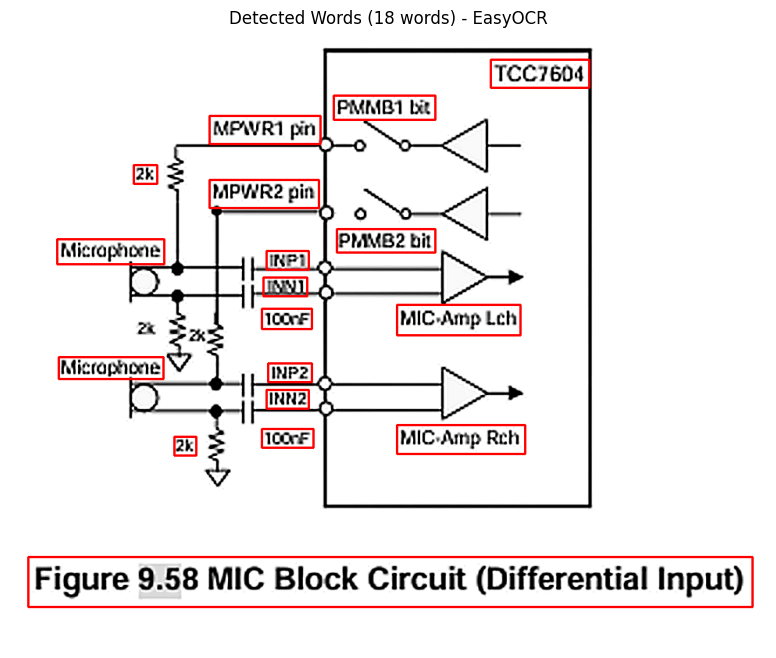

In [33]:
# Step 2: ocr_with_structure 테스트 (EasyOCR 사용)
# 핵심: EasyOCR이 직접 단어 단위로 탐지! (한국어+영어 지원)
# 주의: 첫 실행 시 모델 다운로드가 필요할 수 있습니다 (1-2분 소요)

words_data = ocr_with_structure(img, level='word', langs=['ko', 'en'])

print(f"탐지된 단어 개수: {len(words_data)}")
print(f"\n처음 10개 단어:")
for i, w in enumerate(words_data[:10]):
    print(f"  [{i+1}] '{w['text']}' at ({w['x']}, {w['y']}) conf={w['conf']}% line={w.get('line_num', 'N/A')}")

# 시각화: 탐지된 단어 박스 표시
img_with_boxes = img_rgb.copy()
for w in words_data:
    cv2.rectangle(img_with_boxes, (w['x'], w['y']), (w['x']+w['w'], w['y']+w['h']), (255, 0, 0), 2)

plt.figure(figsize=(14, 8))
plt.title(f"Detected Words ({len(words_data)} words) - EasyOCR")
plt.imshow(img_with_boxes)
plt.axis('off')
plt.show()


그룹화된 라인 개수: 18

각 라인 내용 (처음 15개):
  Line 1 (line_num=0): 'TCCT6DA)'
  Line 2 (line_num=1): 'PMKDI L:'
  Line 3 (line_num=2): 'NPIVRI Ari'
  Line 4 (line_num=3): '자:'
  Line 5 (line_num=4): 'IAPV'R2 pint'
  Line 6 (line_num=5): 'PIAB2 uil'
  Line 7 (line_num=6): 'Kiz(al덧IuIe'
  Line 8 (line_num=7): 'IKI'
  Line 9 (line_num=8): 'IuVI'
  Line 10 (line_num=9): 'IIC Arip L다l'
  Line 11 (line_num=10): 'ICCrF'
  Line 12 (line_num=11): 'Kiz(aryIU-Ie'
  Line 13 (line_num=12): 'IPP2'
  Line 14 (line_num=13): '1HH2'
  Line 15 (line_num=14): 'IIC Anip Ruhi'
  ... (총 18개 라인)


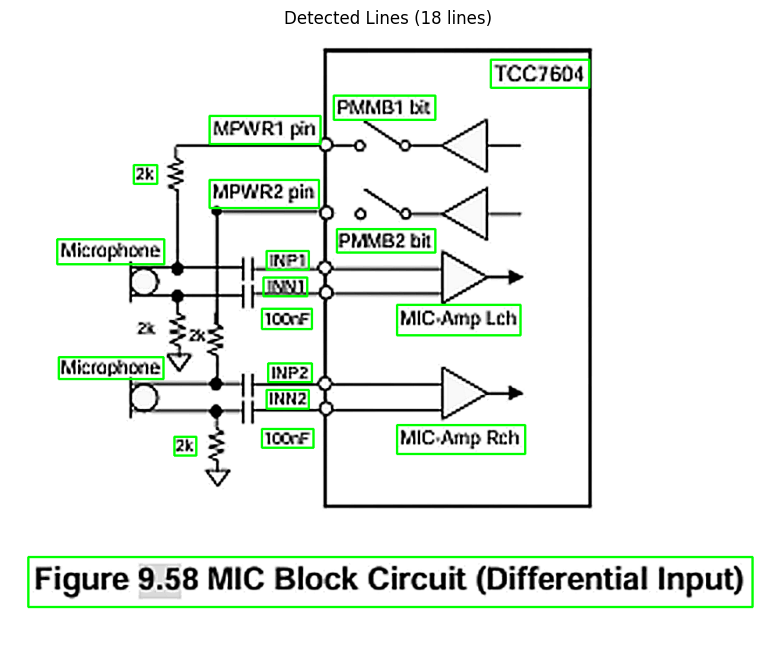

In [34]:


# Step 3: group_by_line 테스트 (라인 단위 그룹화)
lines_data = group_by_line(words_data)

print(f"그룹화된 라인 개수: {len(lines_data)}")
print(f"\n각 라인 내용 (처음 15개):")
for i, line in enumerate(lines_data[:15]):
    preview = line['text'][:60] + '...' if len(line['text']) > 60 else line['text']
    print(f"  Line {i+1} (line_num={line.get('line_num', 'N/A')}): '{preview}'")

if len(lines_data) > 15:
    print(f"  ... (총 {len(lines_data)}개 라인)")

# 시각화: 라인 박스 표시
img_with_lines = img_rgb.copy()
for line in lines_data:
    cv2.rectangle(img_with_lines, (line['x'], line['y']), 
                  (line['x']+line['w'], line['y']+line['h']), (0, 255, 0), 2)

plt.figure(figsize=(14, 8))
plt.title(f"Detected Lines ({len(lines_data)} lines)")
plt.imshow(img_with_lines)
plt.axis('off')
plt.show()


그룹화된 문단 개수: 2

각 문단 내용 (처음 10개):
  Paragraph 1 (para_num=0): 'TCCT6DA) PMKDI L: NPIVRI Ari 자: IAPV'R2 pint PIAB2 uil Kiz(al덧IuIe IKI IuVI IIC ...'
  Paragraph 2 (para_num=1): 'Figure 9.58 MIC Block Circuit (Differential Input)'


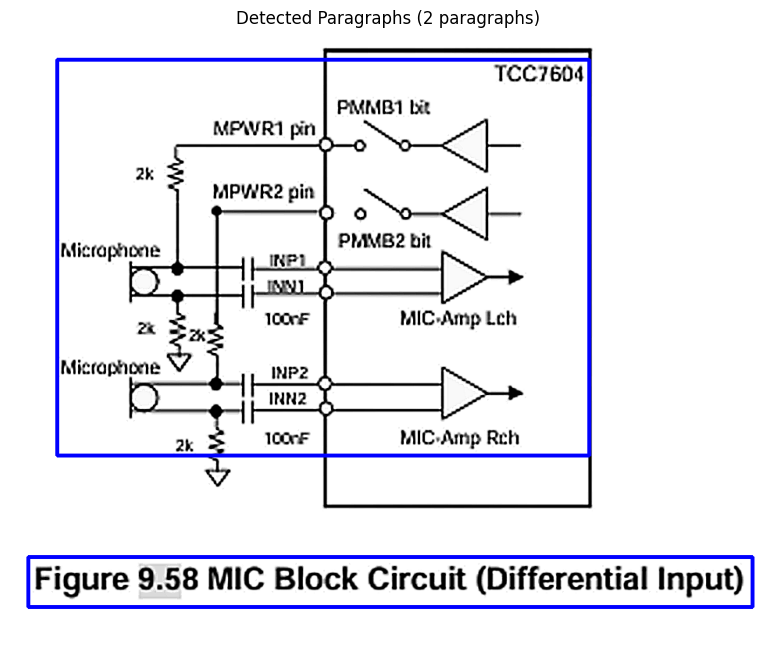

In [35]:
# Step 4: group_by_paragraph 테스트 (문단 단위 그룹화)
# 라인 간격 기반으로 문단 구성 (평균 라인 높이의 1.5배 이상이면 새 문단)
paragraphs_data = group_by_paragraph(words_data, para_threshold_ratio=1.5)

print(f"그룹화된 문단 개수: {len(paragraphs_data)}")
print(f"\n각 문단 내용 (처음 10개):")
for i, para in enumerate(paragraphs_data[:10]):
    preview = para['text'][:80] + '...' if len(para['text']) > 80 else para['text']
    print(f"  Paragraph {i+1} (para_num={para.get('paragraph_num', 'N/A')}): '{preview}'")

if len(paragraphs_data) > 10:
    print(f"  ... (총 {len(paragraphs_data)}개 문단)")

# 시각화: 문단 박스 표시
img_with_paras = img_rgb.copy()
for para in paragraphs_data:
    cv2.rectangle(img_with_paras, (para['x'], para['y']), 
                  (para['x']+para['w'], para['y']+para['h']), (0, 0, 255), 3)

plt.figure(figsize=(14, 8))
plt.title(f"Detected Paragraphs ({len(paragraphs_data)} paragraphs)")
plt.imshow(img_with_paras)
plt.axis('off')
plt.show()


In [29]:
# Step 5: 전체 텍스트 생성 (LLM에 보낼 텍스트)
# 라인 단위로 전체 텍스트 생성
full_text = generate_text_from_data(lines_data)

print("="*60)
print("추출된 전체 텍스트 (라인 단위):")
print("="*60)
print(full_text)
print("="*60)
print(f"\n총 {len(full_text)} 글자")


추출된 전체 텍스트 (라인 단위):
TCCT6DA
PiHDI Li
NPIVRI Airi
과:
IAPVR2 piit
PIAB2 uil
Kiz(al uIe
IKFI
IUVI
IIC 'NnP Lul
ICCrF
Kiz(aluIuie
INP2
IHIH2
IIC Anip R다h
ICCrF
자
Figure 9.58 MIC Block Circuit (Differential Input)

총 188 글자


In [36]:
# Step 5.5: OCR 교정 (LLM을 활용한 오타 수정)
# OCR 결과에 포함된 오류를 LLM으로 자동 교정
LLM_SERVER_URL = "http://gpurent.kogrobo.com:51089/v1"

print("[INFO] OCR 교정 시작...")
print("원본 텍스트에 오류가 있는지 확인하고 수정합니다...\n")

# 전체 텍스트를 LLM으로 교정
corrected_text = call_llm_for_correction(full_text, LLM_SERVER_URL)

if corrected_text != full_text:
    print("="*60)
    print("교정 결과:")
    print("="*60)
    
    # 교정된 텍스트를 라인별로 분할하여 lines_data 업데이트
    corrected_lines = corrected_text.split('\n')
    
    print(f"교정 전 라인 수: {len(lines_data)}")
    print(f"교정 후 라인 수: {len(corrected_lines)}")
    
    # lines_data 업데이트
    for i, line_item in enumerate(lines_data):
        if i < len(corrected_lines):
            original = line_item['text']
            corrected = corrected_lines[i].strip()
            line_item['text'] = corrected
            line_item['corrected'] = (original != corrected)
            
            # 변경된 라인만 표시
            if original != corrected:
                print(f"\n[수정] Line {i+1}:")
                print(f"  원본: {original}")
                print(f"  교정: {corrected}")
        else:
            line_item['corrected'] = False
    
    # 교정된 전체 텍스트 업데이트
    full_text = corrected_text
    
    print("\n" + "="*60)
    print("교정 완료!")
    print("="*60)
else:
    print("[INFO] OCR 교정: 변경사항 없음 (오류가 없거나 감지되지 않음)")
    # 교정되지 않았음을 표시
    for line_item in lines_data:
        line_item['corrected'] = False

print(f"\n교정된 전체 텍스트 (처음 300글자):")
print("-"*60)
print(full_text[:300] + "..." if len(full_text) > 300 else full_text)
print("-"*60)


[INFO] OCR 교정 시작...
원본 텍스트에 오류가 있는지 확인하고 수정합니다...

[INFO] OCR 교정: 변경사항 없음 (오류가 없거나 감지되지 않음)

교정된 전체 텍스트 (처음 300글자):
------------------------------------------------------------
TCCT6DA  
PiHDI Li  
NPIVRI Airi  
and:  
IAPVR2 pin  
PIAB2 UI  
Kiz(al UIe  
IKFI  
IUVI  
IIC 'NnP Lul  
ICCRF  
Kiz(aluIuie  
INP2  
IHIH2  
IIC Anip Rdh  
ICCRF  

Figure 9.58 MIC Block Circuit (Differential Input)
------------------------------------------------------------


In [37]:
# Step 6: LLM 내용 설명 생성
# 교정된 텍스트(full_text)를 사용하여 이미지 내용 설명 생성
# LLM_SERVER_URL은 Step 5.5에서 이미 정의됨

print("[INFO] LLM에 텍스트 전송 중...")
print("교정된 텍스트를 기반으로 이미지 내용을 분석합니다...\n")

description = call_llm_for_description(full_text, LLM_SERVER_URL)

if description:
    print("\n" + "="*60)
    print("LLM 이미지 내용 설명:")
    print("="*60)
    print(description)
    print("="*60)
else:
    print("[WARN] LLM 설명이 생성되지 않았습니다.")


[INFO] LLM에 텍스트 전송 중...
교정된 텍스트를 기반으로 이미지 내용을 분석합니다...


LLM 이미지 내용 설명:
**Figure 9.58 MIC Block Circuit (Differential Input)** 은  
‘마이크(MIC)’용 차동 입력 회로의 블록 다이어그램을 보여주는 그림입니다.  
OCR 결과가 많이 깨졌지만, 전형적인 차동 마이크 프리앰프 회로의 구성 요소들을 추정해 보면 다음과 같은 흐름을 가지고 있습니다.

---

### 1. 입력端 (Differential Input)

- **IN + / IN –** 혹은 **INP1, INP2** 로 표시된 두 개의 입력 핀  
  → 마이크의 차동 신호가 각각 여기로 들어온다.  

- 입력 핀 바로 뒤에 **바이어스 저항**(예: “TCCT6DA”, “PIAB2 UI” 등)과 **커플링 커패시터**(예: “Kiz(Al UIe”)가 배치되어 있어, DC 바이어스를 제공하고 AC 신호만 다음 단계로 전달한다.

### 2. 차동 증폭기 (Differential Amplifier)

- **IC** 라는 표기가 여러 번 등장하는데, 이는 차동 증폭을 담당하는 **연산증폭기(Operational Amplifier)** 혹은 **전용 차동 증폭 IC**를 의미한다.  
  - “ICCRF”, “IIC Anip Rdh” 등은 각각 **IC (Amplifier)**, **IC (Reference)** 등을 가리키는 것으로 보인다.

- 차동 증폭기의 **양극(+)와 음극(–) 입력**에 앞서 언급한 바이어스 저항·커패시터가 연결돼 있어, 입력 신호를 적절히 레벨 시프팅하고 잡음을 억제한다.

### 3. 전원 및 그라운드

- “IAPVR2 pin”, “PIHDI Li” 등은 **전원 핀(VDD, VSS)** 혹은 **전원 레귤레이터**와 연결된 라인을 나타낸다.  
  - 차동 증폭기는 보통 **± V** 전원을 필요로 하므로, 양전원(+V)과 음전원(–V) 혹은 단일 전원 +5 V/3.

In [20]:
# Step 7: 결과 저장
TXT_PATH = "output/output.txt"
CSV_PATH = "output/output.csv"

# 라인 단위로 저장
save_output(lines_data, TXT_PATH, CSV_PATH, description)

print(f"[완료] TXT 저장: {TXT_PATH}")
print(f"[완료] CSV 저장: {CSV_PATH}")
print(f"[완료] 저장된 라인 수: {len(lines_data)}")

# 저장된 파일 미리보기
print("\n" + "="*60)
print("저장된 TXT 파일 내용 (미리보기 - 처음 500글자):")
print("="*60)
with open(TXT_PATH, 'r', encoding='utf-8') as f:
    content = f.read()
    print(content[:500] + "..." if len(content) > 500 else content)
    print(f"\n... (총 {len(content)} 글자)")


[완료] TXT 저장: output/output.txt
[완료] CSV 저장: output/output.csv
[완료] 저장된 라인 수: 40

저장된 TXT 파일 내용 (미리보기 - 처음 500글자):

이미지 내용 설명:
이 그림은 **RAG‑(Retrieval‑Augmented Generation) 기반 멀티‑에이전트 시스템**의 전체 구조와 흐름을 한눈에 보여주는 아키텍처 다이어그램입니다.  
아키텍처는 크게 **사용자 UI**, **API 서버**, **RAG‑코어**, **멀티‑에이전트 엔진**, **벡터 데이터베이스**, **Azure OpenAI**(GPT‑4 Embedding) 로 구성되며, 각 요소가 어떻게 연결되고 어떤 역할을 하는지 단계별로 설명하면 다음과 같습니다.

---

## 1. 전체 구성 요소

| 구분 | 파일·모듈 | 역할 |
|------|-----------|------|
| **프론트엔드** | `StreamlitApp` ( `...

... (총 1943 글자)
